# Import the libraries

In [2]:
import os # to manipulate operating system
import urllib # to download and store the dataset
import numpy as np # to manipulate arrays
import matplotlib.pyplot as plt # for visualization
from matplotlib.image import imread # to read an image
from matplotlib.colors import LogNorm # normalize a given value to the 0-1 range on a log scale
from matplotlib.ticker import FixedLocator, FixedFormatter # set the strings manually for the labels
from sklearn.linear_model import LogisticRegression # classification algorithm
from sklearn.ensemble import RandomForestClassifier # random decision trees classifier
from sklearn.neighbors import KNeighborsClassifier # classification instance based algorithm
from sklearn.cluster import KMeans # k means clustering algorithm
from sklearn.cluster import DBSCAN # clustering algorithm
from sklearn.cluster import MiniBatchKMeans # k means with mini batches
from sklearn.decomposition import PCA # demensionality reduction technique
from sklearn.mixture import GaussianMixture # clustering algorithm based on a probabilistic model
from sklearn.mixture import BayesianGaussianMixture # clustering algorithm of shape ellipsoidal
from sklearn.metrics import silhouette_score # evaluation metric to determine the number of classes k in Kmeans
from sklearn.metrics import silhouette_samples # compute the silhouette coefficient for each sample
from sklearn.model_selection import train_test_split # split the dataset into training and testing
from sklearn.model_selection import StratifiedShuffleSplit # split the dataset using stratified sampling
from sklearn.model_selection import GridSearchCV # to find the best hyperparameter
from sklearn.datasets import make_blobs # making blobs dataset
from sklearn.datasets import make_moons # moons dataset
from sklearn.datasets import load_digits # load mnist dataset
from sklearn.datasets import fetch_olivetti_faces # olivetti faces with 64 * 64 grayscale each image
from sklearn.pipeline import Pipeline # to make pipeline for machine learning system

# K-Means

In [3]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [4]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's plot them:

In [5]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

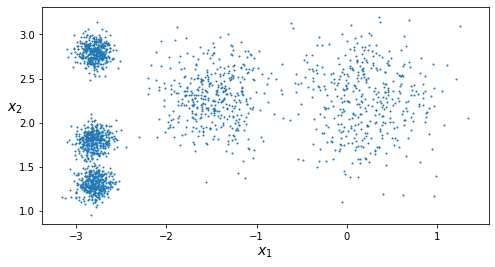

In [6]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()


Fit and predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [7]:
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [8]:
y_pred

array([4, 0, 1, ..., 3, 1, 0], dtype=int32)

In [9]:
y_pred is kmeans.labels_

True

And the following 5 centroids (i.e., cluster centers) were estimated:

In [10]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

We can easily assign new instances to the cluster whose centroid is
closest:

In [11]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 3, 3], dtype=int32)

**Hard Clustering vs Soft Clustering**

Rather than arbitrarily choosing the closest cluster for each instance, which is called hard clustering, it might be better measure the distance of each instance to all 5 centroids. This is what the transform() method does:

In the KMeans class, the `transform()` method measures the
distance from each instance to every centroid:

In [12]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 1.49439034, 2.9042344 , 2.88633901],
       [5.80730058, 2.80290755, 4.4759332 , 5.84739223, 5.84236351],
       [1.21475352, 3.29399768, 1.69136631, 0.29040966, 1.71086031],
       [0.72581411, 3.21806371, 1.54808703, 0.36159148, 1.21567622]])

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a Voronoi diagram:

In [13]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

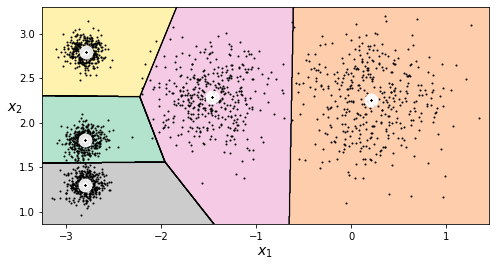

In [14]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

# Centroid initialization methods

In [15]:
## n_init = 1 means set the randomization step of the centroids only once,
## the default in sklearn is n_init = 10
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

In [16]:
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1)

## Inertia
To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the inertia metric:

In [17]:
# performance metric
kmeans.inertia_

211.5985372581684

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's score() method must always respect the "greater is better" rule.

In [18]:
# sklearn's "greater is better" rule
kmeans.score(X)

-211.59853725816836

# Accelerated K-Means and mini-batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches:

In [19]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [20]:
minibatch_kmeans.inertia_

211.6418042769066

In [21]:
minibatch_kmeans.score(X)

-211.6418042769066

We can see that the performance score of `MiniBatchKmeans` is a little worse than the `full Kmeans`. This becomes apparent when we uses a larger dataset.

# Finding the optimal number of clusters

In [22]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

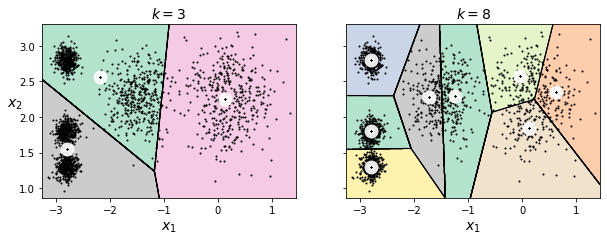

In [23]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [24]:
kmeans_k3.inertia_

653.216719002155

In [25]:
kmeans_k8.inertia_

119.11983416102879

No, we cannot simply take the value of `k` that minimizes the inertia, since it keeps getting lower as we increase `k`. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of `k` and analyze the resulting curve:

In [26]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

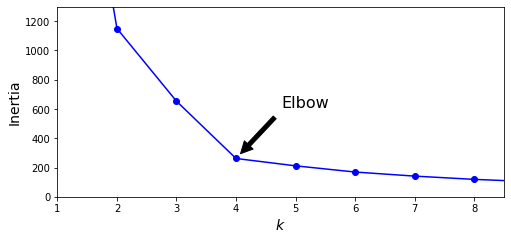

In [27]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

As you can see, there is an elbow at `k=4`, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So `k=4` is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

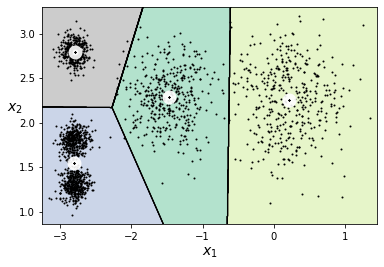

In [28]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the silhouette score, which is the mean silhouette coefficient over all the instances. An instance's silhouette coefficient is equal to `(b - a)/max(a, b)` where `a` is the mean distance to the other instances in the same cluster (it is the mean intra-cluster distance), and `b` is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes `b`, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of `k`:

In [29]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [30]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

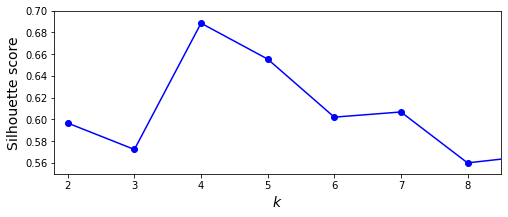

In [31]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that `k = 4` is a very good choice, but it also underlines the fact that `k = 5` is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a silhouette diagram:

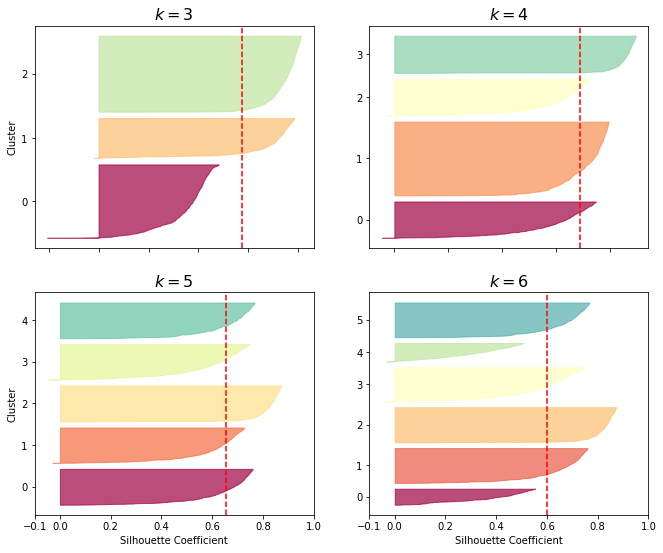

In [32]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

As you can see, `k = 5` looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

# Using Clustering for Image Segmentation

In [33]:
# Download the ladybug image
images_path = os.path.join(".", "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7fedb9361e10>)

In [34]:
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [35]:
X = image.reshape(-1, 3)

In [36]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [37]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

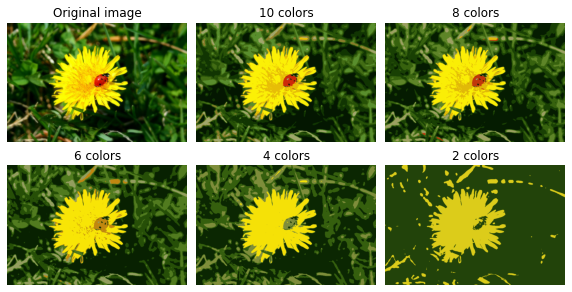

In [38]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

# Using Clustering for Preprocessing
Let's tackle the digits dataset which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.



In [39]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [41]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [42]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:



In [43]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [44]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

How much did the error rate drop?

In [45]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

How about that? We reduced the error rate by over 35%! But we chose the number of clusters `k` completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for `k` is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of `k` is simply the one that results in the best classification performance.

In [46]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.4s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.4s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.4s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.4s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.4s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.4s
[CV] END ...............................kmeans_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ..............................kmeans__n_clusters=55; total time=   7.3s
[CV] END ..............................kmeans__n_clusters=56; total time=   5.5s
[CV] END ..............................kmeans__n_clusters=56; total time=   5.1s
[CV] END ..............................kmeans__n_clusters=56; total time=   5.5s
[CV] END ..............................kmeans__n_clusters=57; total time=   6.0s
[CV] END ..............................kmeans__n_clusters=57; total time=   6.3s
[CV] END ..............................kmeans__n_clusters=57; total time=   5.4s
[CV] END ..............................kmeans__n_clusters=58; total time=   7.8s
[CV] END ..............................kmeans__n_clusters=58; total time=   7.0s
[CV] END ..............................kmeans__n_clusters=58; total time=   5.1s
[CV] END ..............................kmeans__n_clusters=59; total time=   5.8s
[CV] END ..............................kmeans__n_clusters=59; total time=   5.9s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [47]:
grid_clf.best_params_

{'kmeans__n_clusters': 95}

In [48]:
grid_clf.score(X_test, y_test)

0.9777777777777777

# Using Clustering for Semi-Supervised Learning

In [49]:
# Training logistic regression on only 50 training instances
n_labeled = 50
log_reg = LogisticRegression()
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [50]:
log_reg.score(X_test, y_test)

0.8266666666666667

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [51]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

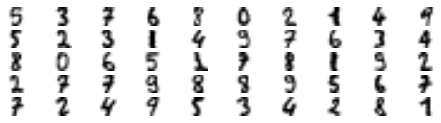

In [52]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [53]:
y_train[representative_digit_idx]

array([5, 3, 7, 6, 8, 0, 2, 1, 4, 9, 5, 2, 3, 1, 4, 9, 7, 6, 3, 4, 8, 0,
       6, 5, 1, 7, 8, 1, 9, 2, 2, 7, 7, 9, 8, 8, 9, 5, 6, 7, 7, 2, 4, 9,
       5, 3, 4, 2, 8, 1])

In [54]:
y_representative_digits = np.array([7, 3, 0, 4, 1, 5, 6, 9, 9, 2, 1, 8, 7, 1, 8, 5, 7, 1, 0, 9, 6, 2,
       7, 1, 3, 6, 4, 9, 4, 4, 9, 7, 9, 4, 1, 3, 4, 7, 8, 2, 6, 2, 5, 2,
       8, 8, 2, 3, 5, 5])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [55]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.057777777777777775

Wow! We jumped from 83.3% accuracy to 91.3%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [56]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [57]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [58]:
log_reg.score(X_test, y_test)

0.05555555555555555

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 75th percentile closest to the centroid:

In [59]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [60]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [61]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [62]:
log_reg.score(X_test, y_test)

0.05555555555555555

A bit better. With just 50 labeled instances (just 5 examples per class on average!), we got 94.0% performance, which is getting closer to the performance of logistic regression on the fully labeled digits dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is close to 96%:

In [63]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.08882235528942116

You could now do a few iterations of active learning:

Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
Train a new model with these additional labels.

In [64]:
X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [65]:
dbscan.labels_[:10]

array([ 0,  1,  0,  2,  3, -1,  0,  0,  4,  1])

In [66]:
# The indices of the core instances
dbscan.core_sample_indices_[:10]

array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 11])

In [67]:
len(dbscan.core_sample_indices_)

790

In [68]:
# the core instances themselves are available in the components_ instance variable:
dbscan.components_[:3]

array([[ 1.73300373, -0.08750471],
       [-0.48737126,  0.87907142],
       [ 1.62255788, -0.263407  ]])

In [69]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [70]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [71]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

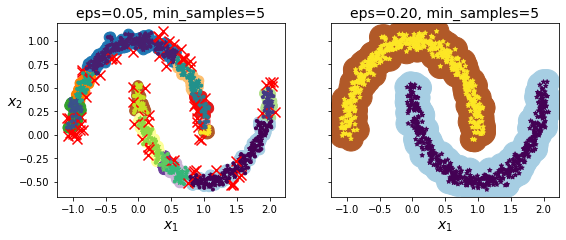

In [72]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [73]:
dbscan = dbscan2

In [74]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [75]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [76]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.22, 0.78],
       [1.  , 0.  ]])

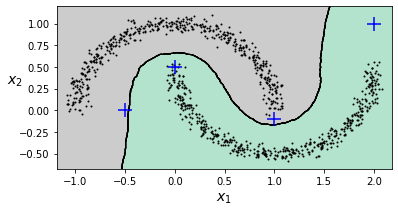

In [77]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

In [78]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

# Gaussian Mixtures

In [79]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Let's train a Gaussian mixture model on the previous dataset:

In [80]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [81]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [82]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [83]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

Did the algorithm actually converge?

In [84]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [85]:
gm.n_iter_

4

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [86]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2])

In [87]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [88]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [89]:
y_new

array([0, 0, 1, 2, 2, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the probability density function (PDF) at any location using the `score_samples()` method:

In [90]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [91]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215021

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [92]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

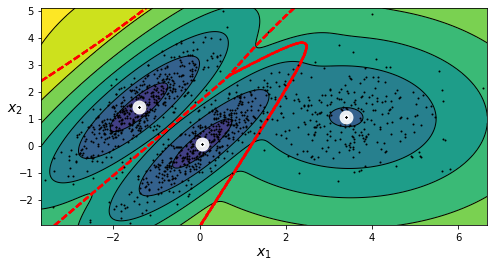

In [93]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:

* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [94]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [95]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

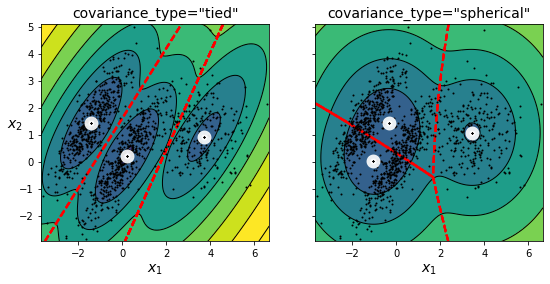

In [96]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.show()

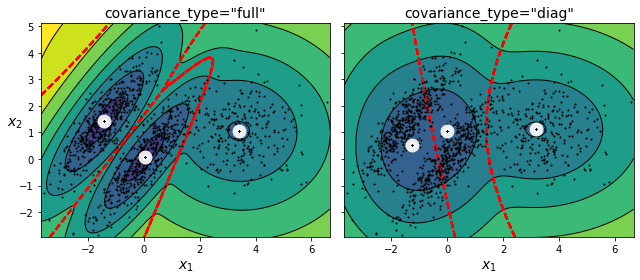

In [97]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

# Anomaly Detection Using Gaussian Mixtures
Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [98]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

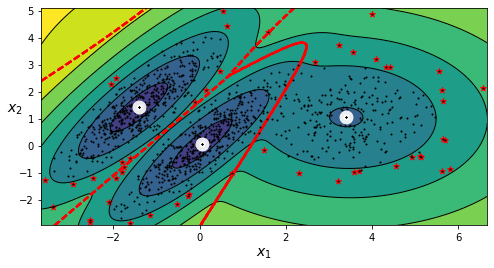

In [99]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

# Selecting the Number of Clusters
We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):


${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$


* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $X$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

In [100]:
gm.bic(X)

8189.747000497186

In [101]:
gm.aic(X)

8102.521720382148

We could compute the BIC manually like this:

In [102]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [103]:
bic, aic

(8189.747000497186, 8102.521720382148)

In [104]:
n_params

17

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [105]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [106]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

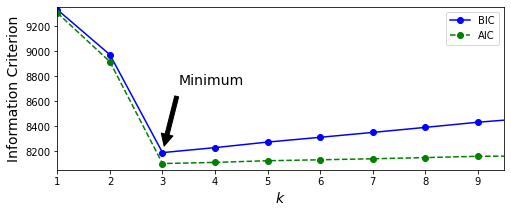

In [107]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

Let's search for best combination of values for both the number of clusters and the covariance_type hyperparameter:

In [108]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [109]:
best_k

3

In [110]:
best_covariance_type

'full'

# Bayesian Gaussian Mixture Models
Rather than manually searching for the optimal number of clusters, it is possible to use instead the `BayesianGaussianMixture` class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

In [111]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

The algorithm automatically detected that only 3 components are needed:

In [112]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

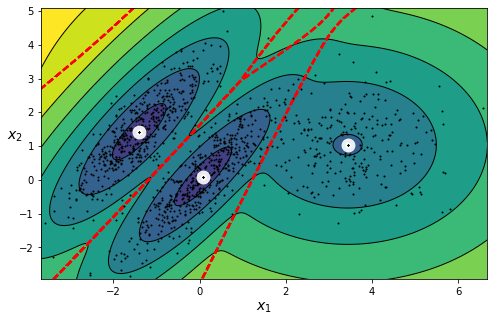

In [113]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [114]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [115]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [116]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

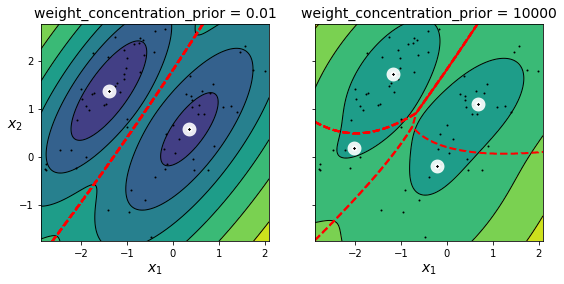

In [117]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

plt.show()

In [118]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [119]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

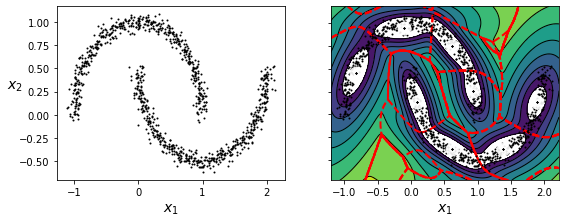

In [120]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

plt.show()

Oops, not great... instead of detecting 2 moon-shaped clusters, the algorithm detected 8 ellipsoidal clusters. However, the density plot does not look too bad, so it might be usable for anomaly detection.

# Exercises
## Exercise no. 10

In [121]:
olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [122]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [123]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [124]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [125]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


To speed things up, we'll reduce the data's dimensionality using PCA:

In [126]:
pca = PCA(0.99) # preserving 99% of its variance 
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

In [127]:
pca.n_components_

199

In [128]:
k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
  print("k={}".format(k))
  kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
  kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


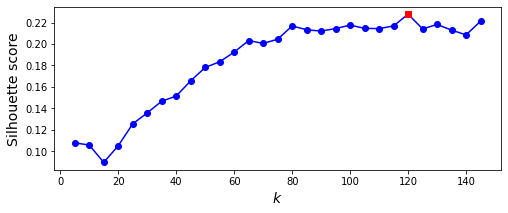

In [129]:
silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [130]:
best_k

120

It looks like the best number of clusters is quite high, at 120. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

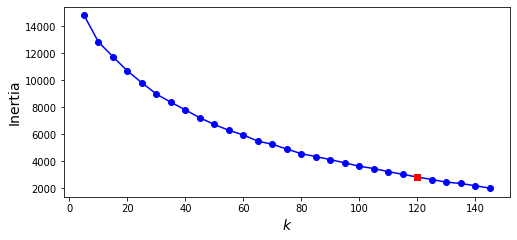

In [131]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()


The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k=120.

In [132]:
best_model = kmeans_per_k[best_index]

Cluster 0


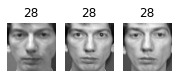

Cluster 1


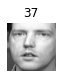

Cluster 2


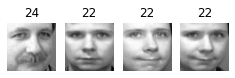

Cluster 3


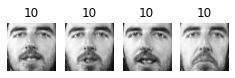

Cluster 4


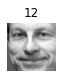

Cluster 5


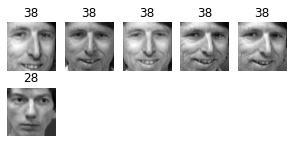

Cluster 6


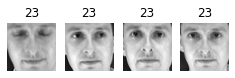

Cluster 7


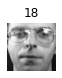

Cluster 8


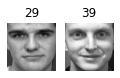

Cluster 9


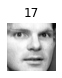

Cluster 10


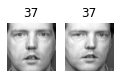

Cluster 11


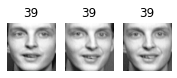

Cluster 12


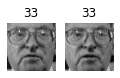

Cluster 13


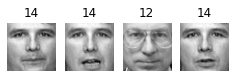

Cluster 14


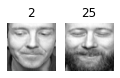

Cluster 15


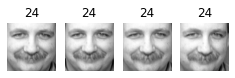

Cluster 16


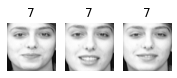

Cluster 17


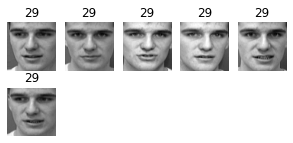

Cluster 18


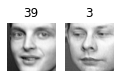

Cluster 19


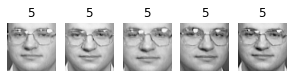

Cluster 20


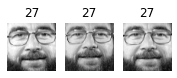

Cluster 21


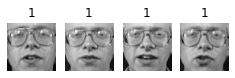

Cluster 22


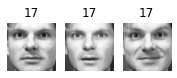

Cluster 23


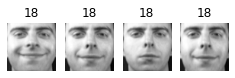

Cluster 24


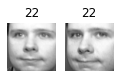

Cluster 25


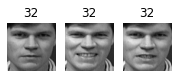

Cluster 26


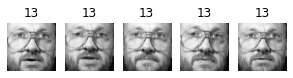

Cluster 27


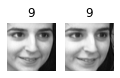

Cluster 28


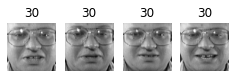

Cluster 29


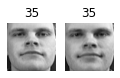

Cluster 30


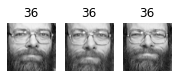

Cluster 31


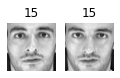

Cluster 32


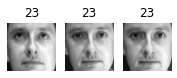

Cluster 33


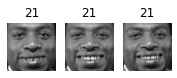

Cluster 34


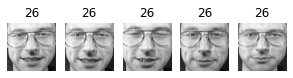

Cluster 35


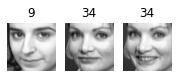

Cluster 36


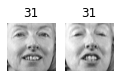

Cluster 37


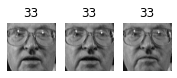

Cluster 38


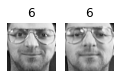

Cluster 39


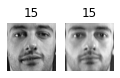

Cluster 40


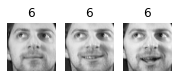

Cluster 41


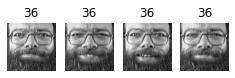

Cluster 42


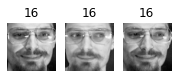

Cluster 43


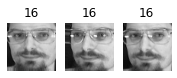

Cluster 44


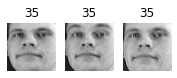

Cluster 45


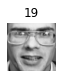

Cluster 46


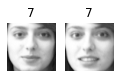

Cluster 47


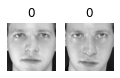

Cluster 48


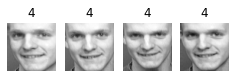

Cluster 49


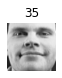

Cluster 50


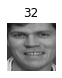

Cluster 51


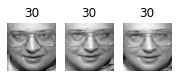

Cluster 52


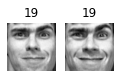

Cluster 53


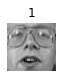

Cluster 54


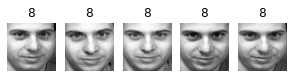

Cluster 55


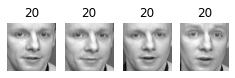

Cluster 56


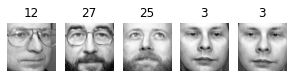

Cluster 57


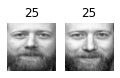

Cluster 58


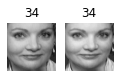

Cluster 59


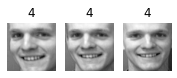

Cluster 60


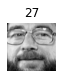

Cluster 61


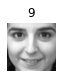

Cluster 62


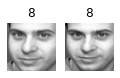

Cluster 63


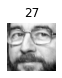

Cluster 64


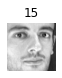

Cluster 65


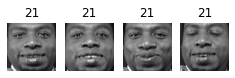

Cluster 66


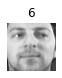

Cluster 67


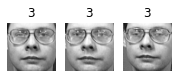

Cluster 68


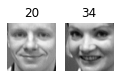

Cluster 69


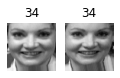

Cluster 70


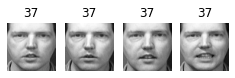

Cluster 71


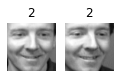

Cluster 72


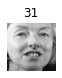

Cluster 73


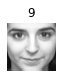

Cluster 74


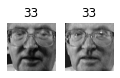

Cluster 75


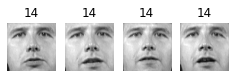

Cluster 76


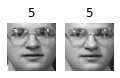

Cluster 77


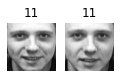

Cluster 78


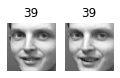

Cluster 79


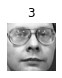

Cluster 80


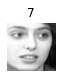

Cluster 81


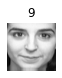

Cluster 82


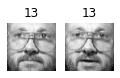

Cluster 83


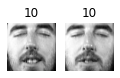

Cluster 84


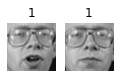

Cluster 85


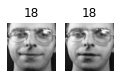

Cluster 86


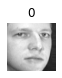

Cluster 87


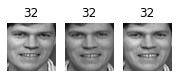

Cluster 88


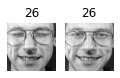

Cluster 89


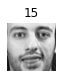

Cluster 90


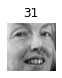

Cluster 91


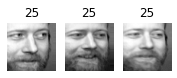

Cluster 92


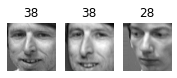

Cluster 93


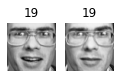

Cluster 94


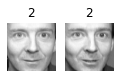

Cluster 95


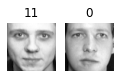

Cluster 96


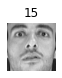

Cluster 97


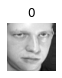

Cluster 98


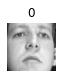

Cluster 99


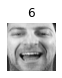

Cluster 100


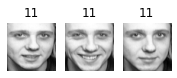

Cluster 101


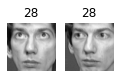

Cluster 102


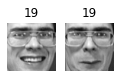

Cluster 103


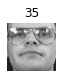

Cluster 104


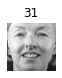

Cluster 105


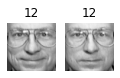

Cluster 106


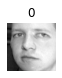

Cluster 107


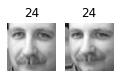

Cluster 108


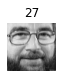

Cluster 109


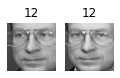

Cluster 110


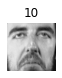

Cluster 111


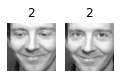

Cluster 112


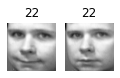

Cluster 113


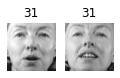

Cluster 114


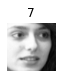

Cluster 115


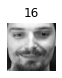

Cluster 116


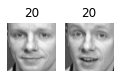

Cluster 117


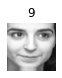

Cluster 118


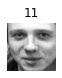

Cluster 119


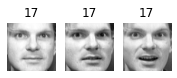

In [133]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model (as we will see below), but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

## Exercise no.11
### Using Clustering as Preprocessing for Classification
*Exercise: Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.*

In [134]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.925

Exercise: Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.

In [135]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.7

Yikes! That's not better at all! Let's see if tuning the number of clusters helps.

*Exercise: Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach?*

We could use a `GridSearchCV` like we did earlier in this notebook, but since we already have a validation set, we don't need K-fold cross-validation, and we're only exploring a single hyperparameter, so it's simpler to just run a loop manually:

In [136]:
for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.3875
10 0.575
15 0.6
20 0.6625
25 0.6625
30 0.6625
35 0.675
40 0.75
45 0.7375
50 0.725
55 0.7125
60 0.7125
65 0.7375
70 0.7375
75 0.7375
80 0.7875
85 0.75
90 0.75
95 0.7125
100 0.775
105 0.75
110 0.725
115 0.7625
120 0.7
125 0.75
130 0.725
135 0.7375
140 0.7625
145 0.6875


Oh well, even by tuning the number of clusters, we never get beyond 80% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images.

*Exercise: What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?*

In [137]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [138]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.8125

That's a bit better, but still worse than without the cluster features. The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

## Exercise no. 12
### A Gaussian Mixture Model for the Olivetti Faces Dataset
*Exercise: Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset's dimensionality (e.g., use PCA, preserving 99% of the variance).*

In [139]:
gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*Exercise: Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method).*

In [140]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

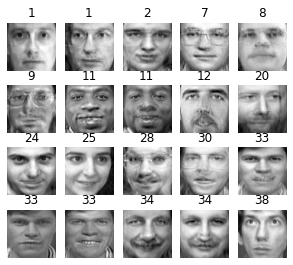

In [141]:
plot_faces(gen_faces, y_gen_faces)

*Exercise: Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the `score_samples()` method for normal images and for anomalies).*

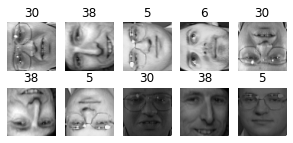

In [142]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [143]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [144]:
gm.score_samples(X_bad_faces_pca)

array([-2.43643201e+07, -1.89784913e+07, -3.78112127e+07, -4.98187810e+07,
       -3.20479064e+07, -1.37531270e+07, -2.92373884e+07, -1.05488947e+08,
       -1.19575317e+08, -6.74256365e+07])

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [145]:
gm.score_samples(X_train_pca[:10])

array([1163.0202093 , 1134.03637915, 1156.32132775, 1170.6760289 ,
       1141.45404755, 1154.35205161, 1091.328946  , 1111.41149464,
       1096.43049154, 1132.98982603])

## Exercise no. 13
### Using Dimensionality Reduction Techniques for Anomaly Detection
*Exercise: Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.*

We already reduced the dataset using PCA earlier:

In [146]:
X_train_pca

array([[ 3.78081870e+00, -1.85478783e+00, -5.14404106e+00, ...,
        -1.35633215e-01, -2.14082390e-01,  6.11918792e-02],
       [ 1.01488552e+01, -1.52754641e+00, -7.66972005e-01, ...,
         1.23938702e-01, -1.35264218e-01, -2.32756715e-02],
       [-1.00152893e+01,  2.87729931e+00, -9.19886231e-01, ...,
         7.26091713e-02, -2.96061928e-03,  1.24891475e-01],
       ...,
       [ 2.47586775e+00,  2.95597267e+00,  1.29985702e+00, ...,
        -2.09132396e-02,  3.48520577e-02, -1.54326335e-01],
       [-3.22031188e+00,  5.34898090e+00,  1.39427006e+00, ...,
         5.75526841e-02, -2.28311747e-01,  1.55578002e-01],
       [-9.22877133e-01, -3.64703012e+00,  2.26088071e+00, ...,
         1.36853680e-01, -6.91293478e-02,  6.26830086e-02]], dtype=float32)

In [147]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [148]:
reconstruction_errors(pca, X_train).mean()

0.0001920535

In [149]:
reconstruction_errors(pca, X_bad_faces).mean()

0.004707354

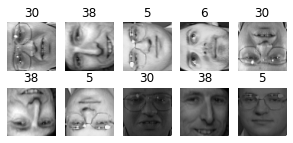

In [150]:
plot_faces(X_bad_faces, y_bad)

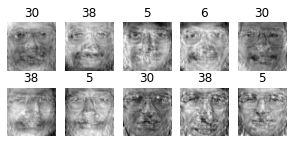

In [151]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)